# トレンド識別手法のデモ

In [1]:
# ライブラリのインポート
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import pandas_ta as ta
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# 銘柄の指定とデータのダウンロード  1591:日経400連動ETF
symbol = '1591.T'
# Download the stock data
ticker = symbol
start_date = '2023-03-01'
end_date = '2024-08-01'
df = yf.download(ticker, start=start_date, end=end_date)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# リターンの計算関数
def calculate_returns(df_for_returns, col_for_returns = 'Close', col_for_signal = 'Trend'):

    stats = {}

    # Calculate daily returns
    df_for_returns['Daily_Returns'] = df_for_returns[col_for_returns].pct_change()
    df_for_returns['Returns'] = df_for_returns['Daily_Returns'] * df_for_returns[col_for_signal].shift(1)
    df_for_returns['Returns'] = df_for_returns['Returns'].fillna(0)
    df_for_returns['Equity Curve'] = 100 * (1 + df_for_returns['Returns']).cumprod()

    equity_curve = df_for_returns['Equity Curve']
    # Calculate the running maximum of the equity curve
    cumulative_max = equity_curve.cummax()
    drawdown = (equity_curve - cumulative_max) / cumulative_max
    stats['max_drawdown'] = drawdown.min()

    # calculate the sharpe ratio
    stats['sharpe_ratio'] = (df_for_returns['Returns'].mean() / df_for_returns['Returns'].std()) * np.sqrt(252)

    # calculate the total return
    stats['total_return'] = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1

    # calculate the number of long signals
    stats['number_of_long_signals'] = len(df_for_returns[df_for_returns[col_for_signal] == 1])

    # calculate the number of short signals
    stats['number_of_short_signals'] = len(df_for_returns[df_for_returns[col_for_signal] == -1])

    return df_for_returns['Equity Curve'], stats

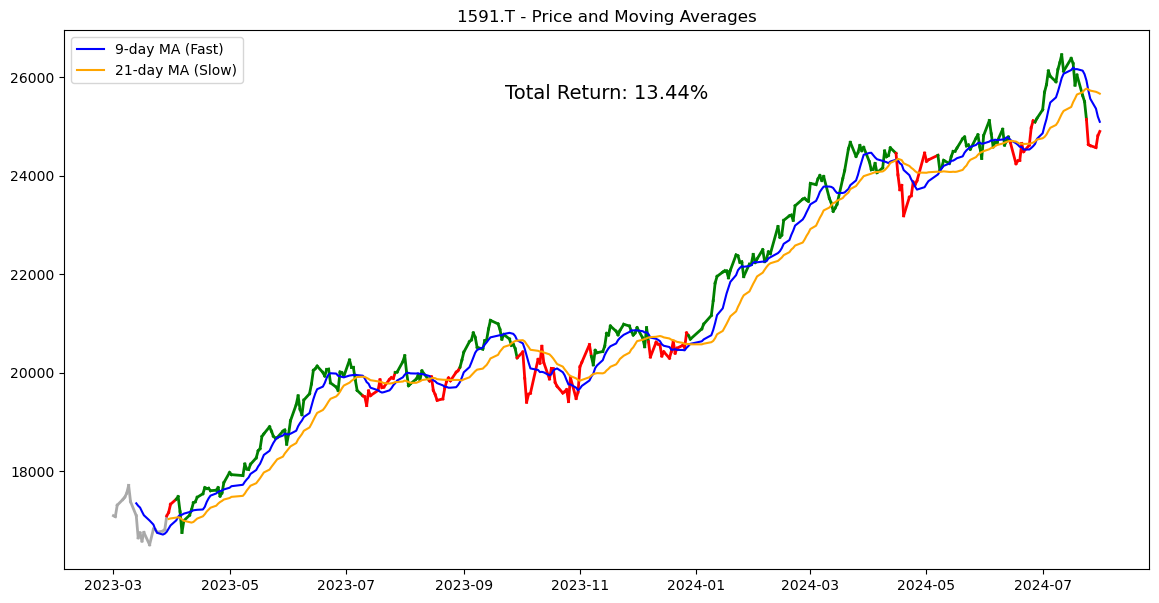

In [5]:
# トレンド識別手法(1) 長短移動平均の位置関係
def calculate_trend_2_ma(df_ohlc, period_slow=21, period_fast=9):
    # Calculate Moving Averages (fast and slow) using pandas_ta
    df_ohlc['MA_Fast'] = df_ohlc.ta.sma(close='Close', length=period_fast)
    df_ohlc['MA_Slow'] = df_ohlc.ta.sma(close='Close', length=period_slow)

    # Determine the trend based on Moving Averages
    def identify_trend(row):
        if row['MA_Fast'] > row['MA_Slow']:
            return 1
        elif row['MA_Fast'] < row['MA_Slow']:
            return -1
        else:
            return 0
        
    df_ohlc = df_ohlc.assign(Trend=df_ohlc.apply(identify_trend, axis=1))
    df_ohlc['Trend'] =  df_ohlc['Trend'].fillna('0')

    return df_ohlc['Trend']

df['Trend'] = calculate_trend_2_ma(df, period_slow=21, period_fast=9)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'Close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7), sharex=True)

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Trend'].iloc[i] == 1 else 
                   ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_Fast'], label='9-day MA (Fast)', color='blue')
ax1.plot(df['MA_Slow'], label='21-day MA (Slow)', color='orange')
ax1.set_title(f'{ticker} - Price and Moving Averages')
ax1.text(0.5, 0.9, f'Total Return: {stats['total_return']:.2%}', transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.legend(loc='best')

plt.show()

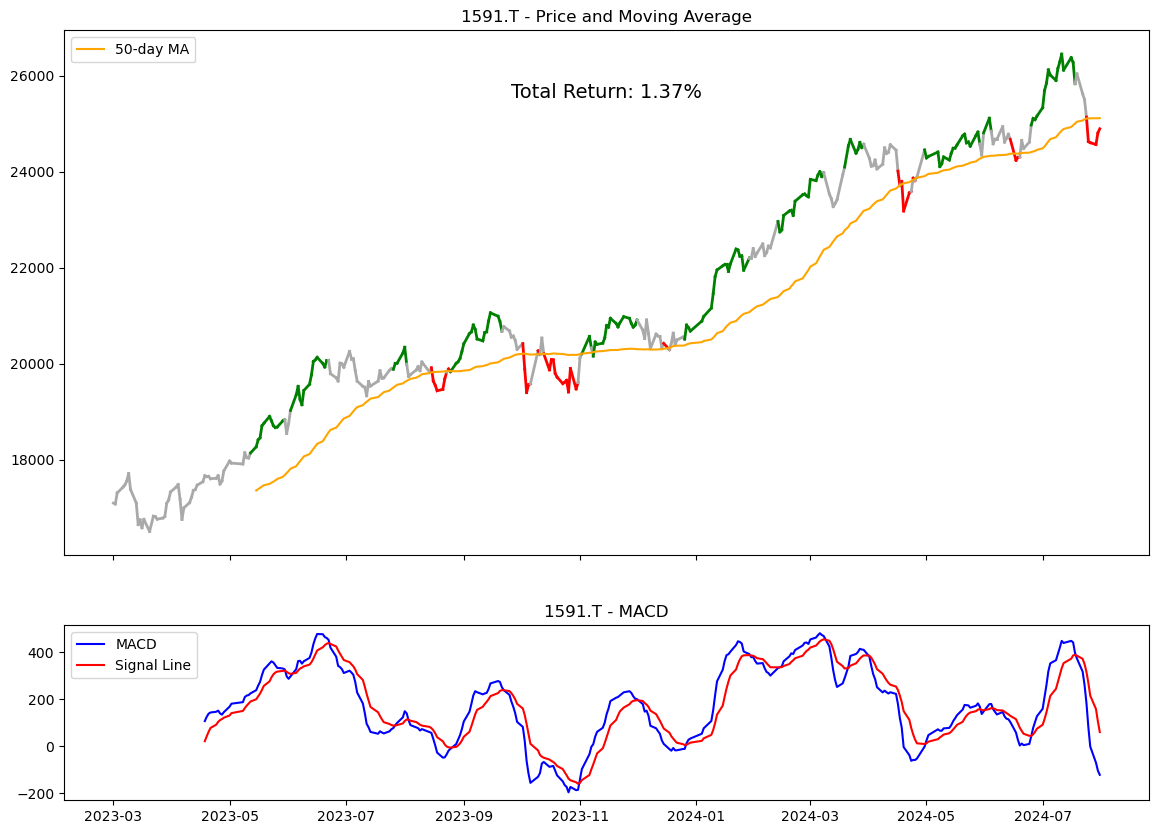

In [6]:
# トレンド識別手法 (2) 終値と長期移動平均の位置関係及びMACDとMACDsignalの位置関係
def calculate_trend_macd_ma(df_ohlc, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9):
    # Calculate MACD using pandas_ta
    df_ohlc.ta.macd(close='Close', fast=macd_fast, slow=macd_slow, signal=macd_signal, append=True)

    # Calculate Moving Average
    df_ohlc['MA'] = df_ohlc.ta.sma(close='Close', length=ma_period)

    # Determine the trend based on MA and MACD
    def identify_trend(row):
        macd_name = f'{macd_fast}_{macd_slow}_{macd_signal}'
        if row['Close'] > row['MA'] and row[f'MACD_{macd_name}'] > row[f'MACDs_{macd_name}']:
            return 1
        elif row['Close'] < row['MA'] and row[f'MACD_{macd_name}'] < row[f'MACDs_{macd_name}']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_macd_ma(df, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'Close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Trend'].iloc[i] == 1 else 
                   ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot the Moving Average
ax1.plot(df['MA'], label=f'50-day MA', color='orange')
ax1.set_title(f'{ticker} - Price and Moving Average')
ax1.text(0.5, 0.9, f'Total Return: {stats['total_return']:.2%}', transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.legend(loc='best')

# Plot MACD and Signal Line on the second subplot (smaller height)
ax2.plot(df.index, df['MACD_12_26_9'], label='MACD', color='blue')
ax2.plot(df.index, df['MACDs_12_26_9'], label='Signal Line', color='red')
ax2.set_title(f'{ticker} - MACD')
ax2.legend(loc='best')

plt.show()

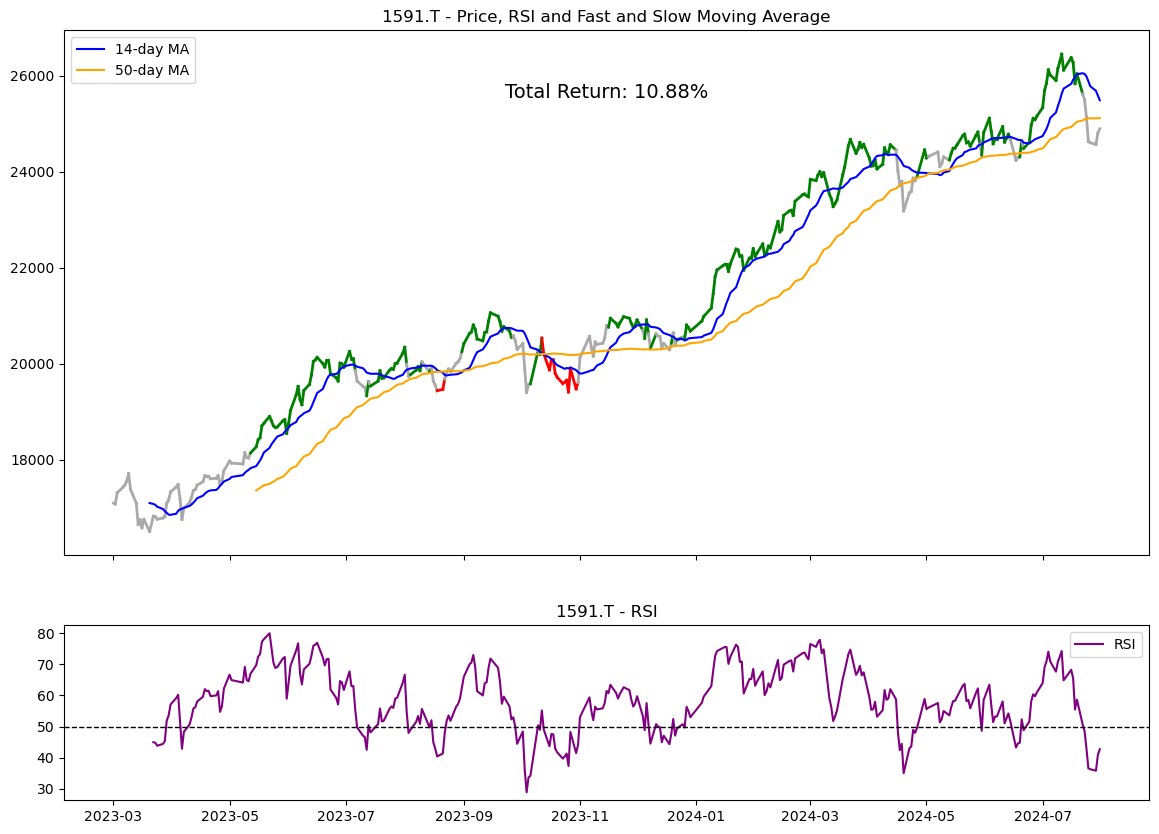

In [7]:
# トレンド識別手法 (3) RSIの位置及び長短移動平均の位置関係
def calculate_trend_rsi_ma(df_ohlc, rsi_period=14, ma_fast=9, ma_slow=21):

    # Calculate RSI using pandas_ta
    df_ohlc['RSI'] = df.ta.rsi(close='Close', length=rsi_period)

    # Calculate Moving Averages (14-day and 50-day) using pandas_ta
    df_ohlc[f'MA_{ma_fast}'] = df_ohlc.ta.sma(close='Close', length=14)
    df_ohlc[f'MA_{ma_slow}'] = df_ohlc.ta.sma(close='Close', length=50)

    # Determine the trend based on RSI and Moving Averages
    def identify_trend(row):
        if row['RSI'] > 50 and row[f'MA_{ma_fast}'] > row[f'MA_{ma_slow}']:
            return 1
        elif row['RSI'] < 50 and row[f'MA_{ma_fast}'] < row[f'MA_{ma_slow}']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_rsi_ma(df, rsi_period=14, ma_fast=14, ma_slow=50)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'Close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Trend'].iloc[i] == 1 else 
                   ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_14'], label='14-day MA', color='blue')
ax1.plot(df['MA_50'], label='50-day MA', color='orange')
ax1.text(0.5, 0.9, f'Total Return: {stats['total_return']:.2%}', transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price, RSI and Fast and Slow Moving Average')
ax1.legend(loc='best')

# Plot RSI on the second subplot (smaller height)
ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
ax2.axhline(50, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at RSI=50
ax2.set_title(f'{ticker} - RSI')
ax2.legend(loc='best')

plt.show()

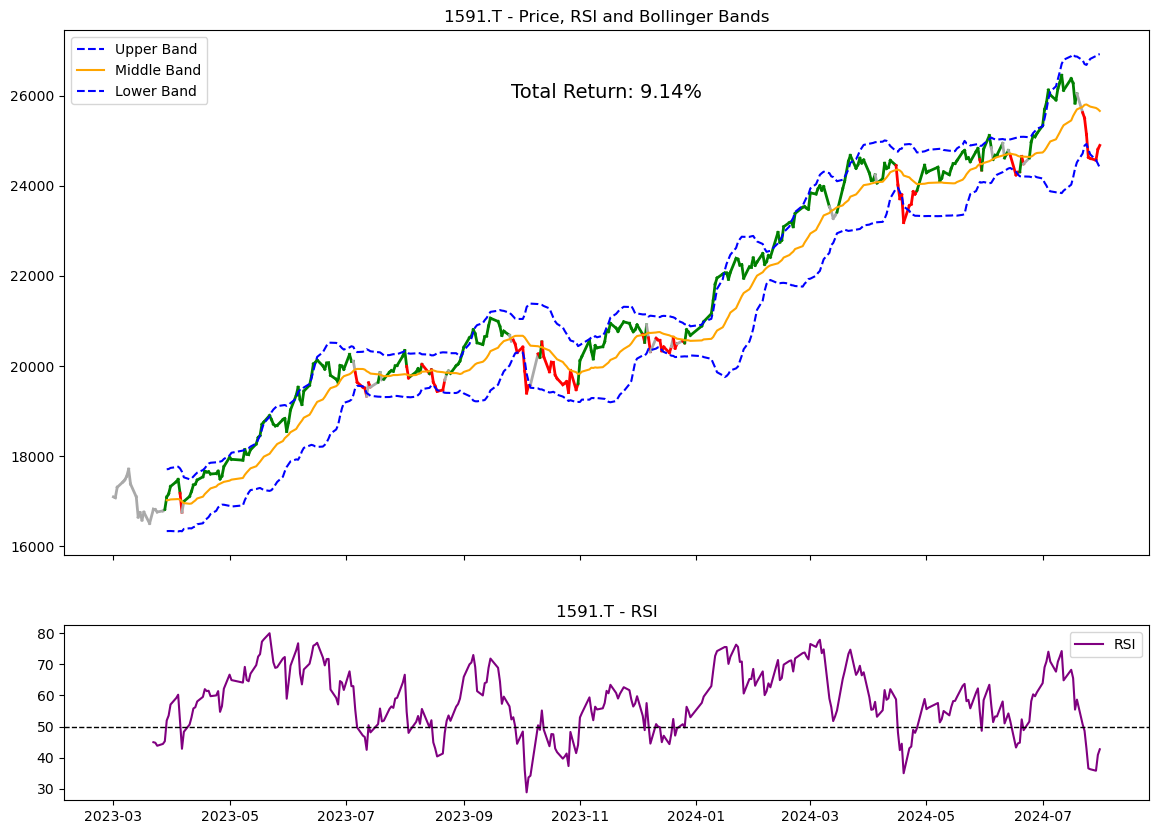

In [8]:
# トレンド識別手法 (4) 終値、ボリンジャーバンド、RSIの位置関係
def calculate_trend_bbands_rsi(df_ohlc, bbands_period=5, bbands_std=2, rsi_period=14):

    # Calculate RSI using pandas_ta
    df_ohlc['RSI'] = df_ohlc.ta.rsi(close='Close', length=rsi_period)

    # Calculate Bollinger Bands using pandas_ta
    bbands = df.ta.bbands(close='Close', length=bbands_period, std=bbands_std)
    df_ohlc['BB_upper'] = bbands[f'BBU_{bbands_period}_{bbands_std}.0']
    df_ohlc['BB_middle'] = bbands[f'BBM_{bbands_period}_{bbands_std}.0']
    df_ohlc['BB_lower'] = bbands[f'BBL_{bbands_period}_{bbands_std}.0']

    # Determine the trend based on Bollinger Bands and RSI
    def identify_trend(row):
        if row['Close'] > row['BB_middle'] and row['RSI'] > 50:
            return 1
        elif row['Close'] < row['BB_middle'] and row['RSI'] < 50:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_bbands_rsi(df, bbands_period=20, bbands_std=2, rsi_period=14)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'Close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Trend'].iloc[i] == 1 else 
                   ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot Bollinger Bands
ax1.plot(df['BB_upper'], label='Upper Band', color='blue', linestyle='--')
ax1.plot(df['BB_middle'], label='Middle Band', color='orange')
ax1.plot(df['BB_lower'], label='Lower Band', color='blue', linestyle='--')
ax1.text(0.5, 0.9, f'Total Return: {stats['total_return']:.2%}', transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price, RSI and Bollinger Bands')
ax1.legend(loc='best')

# Plot RSI on the second subplot (smaller height)
ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
ax2.axhline(50, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at RSI=50
ax2.set_title(f'{ticker} - RSI')
ax2.legend(loc='best')

plt.show()

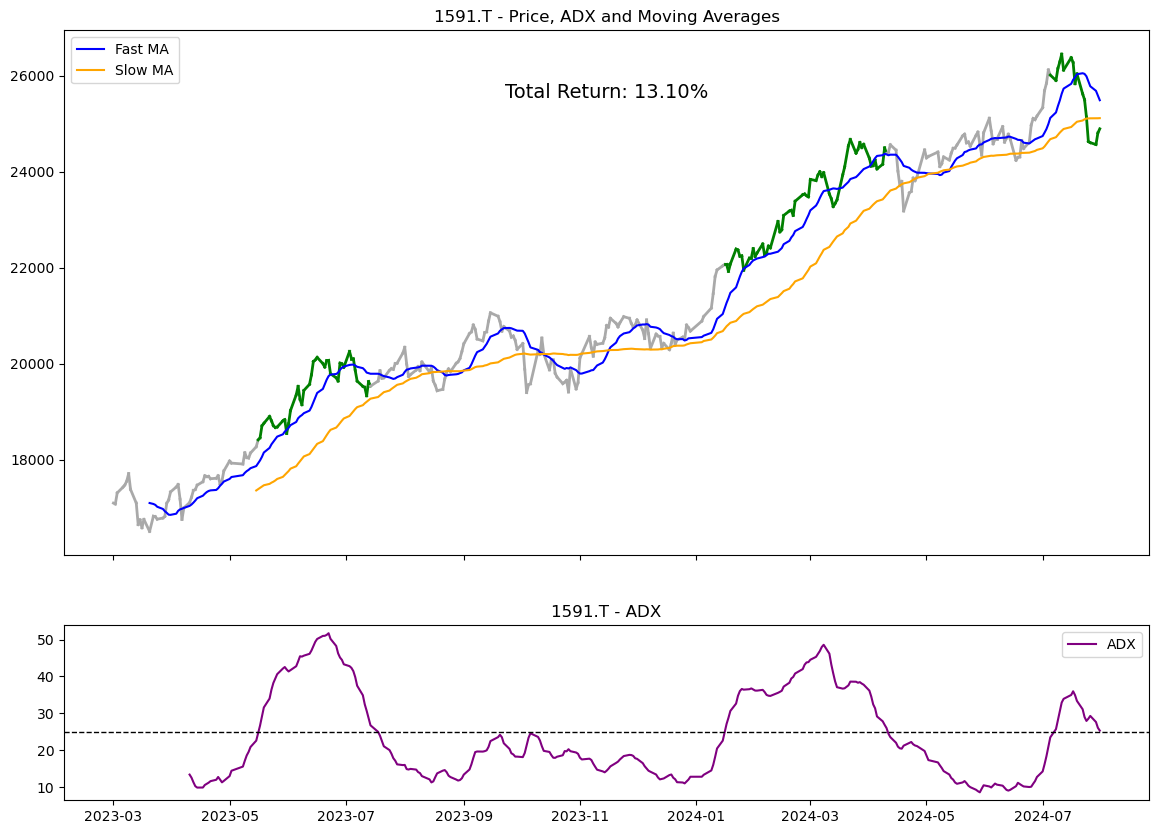

In [9]:
# トレンド識別手法 (5) ADXの位置及び長短移動平均の位置関係
def calculate_trend_adx_ma(df_ohlc, adx_period=14, fast_ma_period=14, slow_ma_period=50):
    # Calculate ADX using pandas_ta
    df_ohlc['ADX'] = df_ohlc.ta.adx(length=adx_period)[f'ADX_{adx_period}']

    # Calculate Moving Averages (14-day and 50-day) using pandas_ta
    df_ohlc['MA_fast'] = df_ohlc.ta.sma(close='Close', length=fast_ma_period)
    df_ohlc['MA_slow'] = df_ohlc.ta.sma(close='Close', length=slow_ma_period)

    # Determine the trend based on ADX and Moving Averages
    def identify_trend(row):
        if row['ADX'] > 25 and row['MA_fast'] > row['MA_slow']:
            return 1
        elif row['ADX'] > 25 and row['MA_fast'] < row['MA_slow']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_adx_ma(df, adx_period=14, fast_ma_period=14, slow_ma_period=50)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'Close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Trend'].iloc[i] == 1 else 
                   ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot the Moving Averages
ax1.plot(df['MA_fast'], label='Fast MA', color='blue')
ax1.plot(df['MA_slow'], label='Slow MA', color='orange')
ax1.text(0.5, 0.9, f'Total Return: {stats['total_return']:.2%}', transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price, ADX and Moving Averages')
ax1.legend(loc='best')

# Plot ADX on the second subplot (smaller height)
ax2.plot(df.index, df['ADX'], label='ADX', color='purple')
ax2.axhline(25, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at ADX=25
ax2.set_title(f'{ticker} - ADX')
ax2.legend(loc='best')

plt.show()

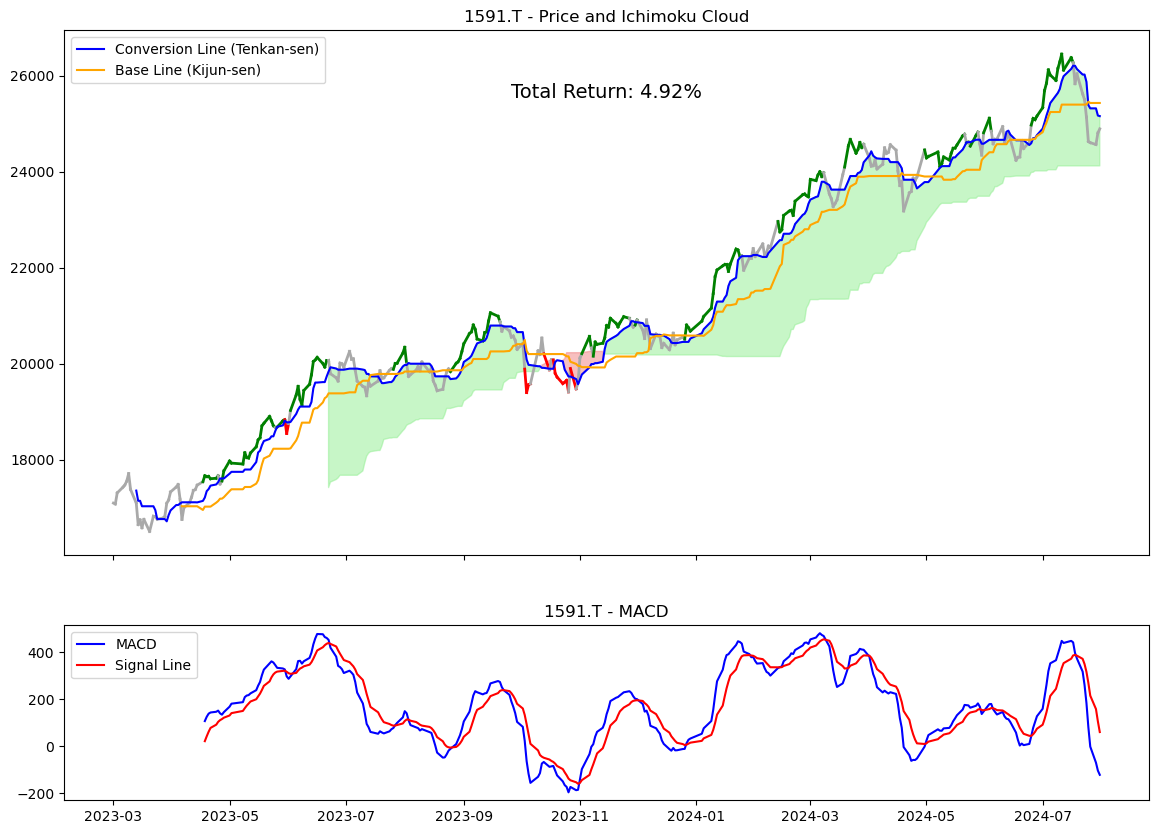

In [10]:
# トレンド識別手法 (6) 終値と一目均衡表の雲の位置関係及びMACDとMACDsignalの位置関係
def calculate_trend_ichimoku_macd(df_ohlc, macd_fast=12, macd_slow=26, macd_signal=9, tenkan=9, kijun=26, senkou=52):

    # Calculate Ichimoku Cloud components using pandas_ta
    df_ichimoku = df_ohlc.ta.ichimoku(tenkan, kijun, senkou)[0]

    # Extract Ichimoku Cloud components
    df_ohlc['Ichimoku_Conversion'] = df_ichimoku[f'ITS_{tenkan}']  # Tenkan-sen (Conversion Line)
    df_ohlc['Ichimoku_Base'] = df_ichimoku[f'IKS_{kijun}']       # Kijun-sen (Base Line)
    df_ohlc['Ichimoku_Span_A'] = df_ichimoku[f'ITS_{tenkan}']         # Senkou Span A
    df_ohlc['Ichimoku_Span_B'] = df_ichimoku[f'ISB_{kijun}']        # Senkou Span B

    # Calculate MACD using pandas_ta
    df_ohlc.ta.macd(close='Close', fast=macd_fast, slow=macd_slow, signal=macd_signal, append=True)

    # Determine the trend based on Ichimoku Cloud and MACD
    def identify_trend(row):
        if row['Close'] > max(row['Ichimoku_Span_A'], row['Ichimoku_Span_B']) and row['MACD_12_26_9'] > row['MACDs_12_26_9']:
            return 1
        elif row['Close'] < min(row['Ichimoku_Span_A'], row['Ichimoku_Span_B']) and row['MACD_12_26_9'] < row['MACDs_12_26_9']:
            return -1
        else:
            return 0

    df_ohlc['Trend'] = df_ohlc.apply(identify_trend, axis=1)
    return df_ohlc['Trend']

df['Trend'] = calculate_trend_ichimoku_macd(df, macd_fast=12, macd_slow=26, macd_signal=9)
df['Equity Curve'], stats = calculate_returns(df, col_for_returns = 'Close', col_for_signal = 'Trend')

# Plotting with adjusted subplot heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Plotting the close price with the color corresponding to the trend
for i in range(1, len(df)):
    ax1.plot(df.index[i-1:i+1], df['Close'].iloc[i-1:i+1], 
             color='green' if df['Trend'].iloc[i] == 1 else 
                   ('red' if df['Trend'].iloc[i] == -1 else 'darkgrey'), linewidth=2)

# Plot Ichimoku Cloud
ax1.fill_between(df.index, df['Ichimoku_Span_A'], df['Ichimoku_Span_B'], 
                 where=(df['Ichimoku_Span_A'] >= df['Ichimoku_Span_B']), color='lightgreen', alpha=0.5)
ax1.fill_between(df.index, df['Ichimoku_Span_A'], df['Ichimoku_Span_B'], 
                 where=(df['Ichimoku_Span_A'] < df['Ichimoku_Span_B']), color='lightcoral', alpha=0.5)

ax1.plot(df['Ichimoku_Conversion'], label='Conversion Line (Tenkan-sen)', color='blue')
ax1.plot(df['Ichimoku_Base'], label='Base Line (Kijun-sen)', color='orange')
ax1.text(0.5, 0.9, f'Total Return: {stats['total_return']:.2%}', transform=ax1.transAxes, ha='center', va='top', fontsize=14)
ax1.set_title(f'{ticker} - Price and Ichimoku Cloud')
ax1.legend(loc='best')

# Plot MACD and Signal Line on the second subplot (smaller height)
ax2.plot(df.index, df['MACD_12_26_9'], label='MACD', color='blue')
ax2.plot(df.index, df['MACDs_12_26_9'], label='Signal Line', color='red')
ax2.set_title(f'{ticker} - MACD')
ax2.legend(loc='best')

plt.show()

In [11]:
# 単一の銘柄について、上記の6つの手法のバックテストの結果一覧
# Download the stock data
ticker = symbol  # You can replace 'AAPL' with any other stock ticker or currency pair
df = yf.download(ticker, start=start_date, end=end_date)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

trend_identification_methods = ['2_ma', 'macd_ma', 'rsi_ma', 'bbands_rsi', 'adx_ma',  'ichimoku_macd']
trend_identification_results = []

def calculate_trend(df, method):
    if method == '2_ma':
        return calculate_trend_2_ma(df, period_slow=21, period_fast=9)
    elif method == 'macd_ma':
        return calculate_trend_macd_ma(df, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9)
    elif method == 'rsi_ma':
        return calculate_trend_rsi_ma(df, rsi_period=14, ma_fast=9, ma_slow=21)
    elif method == 'bbands_rsi':
        return calculate_trend_bbands_rsi(df, bbands_period=5, bbands_std=2, rsi_period=14)
    elif method == 'adx_ma':
        return calculate_trend_adx_ma(df, adx_period=14, fast_ma_period=14, slow_ma_period=50)
    elif method == 'ichimoku_macd':
        return calculate_trend_ichimoku_macd(df, macd_fast=12, macd_slow=26, macd_signal=9, tenkan=9, kijun=26, senkou=52)

for method in trend_identification_methods:

    # Calculate results of returns for each method and append to the list
    df_copy = df.copy()
    d = {}
    d['Method'] = method
    df_copy['Trend'] = calculate_trend(df_copy, method)
    df_copy['Equity Curve'], stats = calculate_returns(df_copy, col_for_returns = 'Close', col_for_signal = 'Trend')
    d.update(stats)
    trend_identification_results.append(d)

    # Add trend line and equity curve to the df
    df[f'Trend_{method}'] = df_copy['Trend']
    df[f'Equity Curve_{method}'] = df_copy['Equity Curve']


trend_identification_results_df = pd.DataFrame(trend_identification_results)

trend_identification_results_df

[*********************100%***********************]  1 of 1 completed


,Method,max_drawdown,sharpe_ratio,total_return,number_of_long_signals,number_of_short_signals
0,2_ma,-0.099889,0.691817,0.134427,236,94
1,macd_ma,-0.098601,0.147011,0.013744,148,38
2,rsi_ma,-0.140358,0.702318,0.108827,212,15
3,bbands_rsi,-0.171308,0.681391,0.115030,194,53
4,adx_ma,-0.071191,1.083635,0.130963,118,0
5,ichimoku_macd,-0.103752,0.422403,0.049183,151,13


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


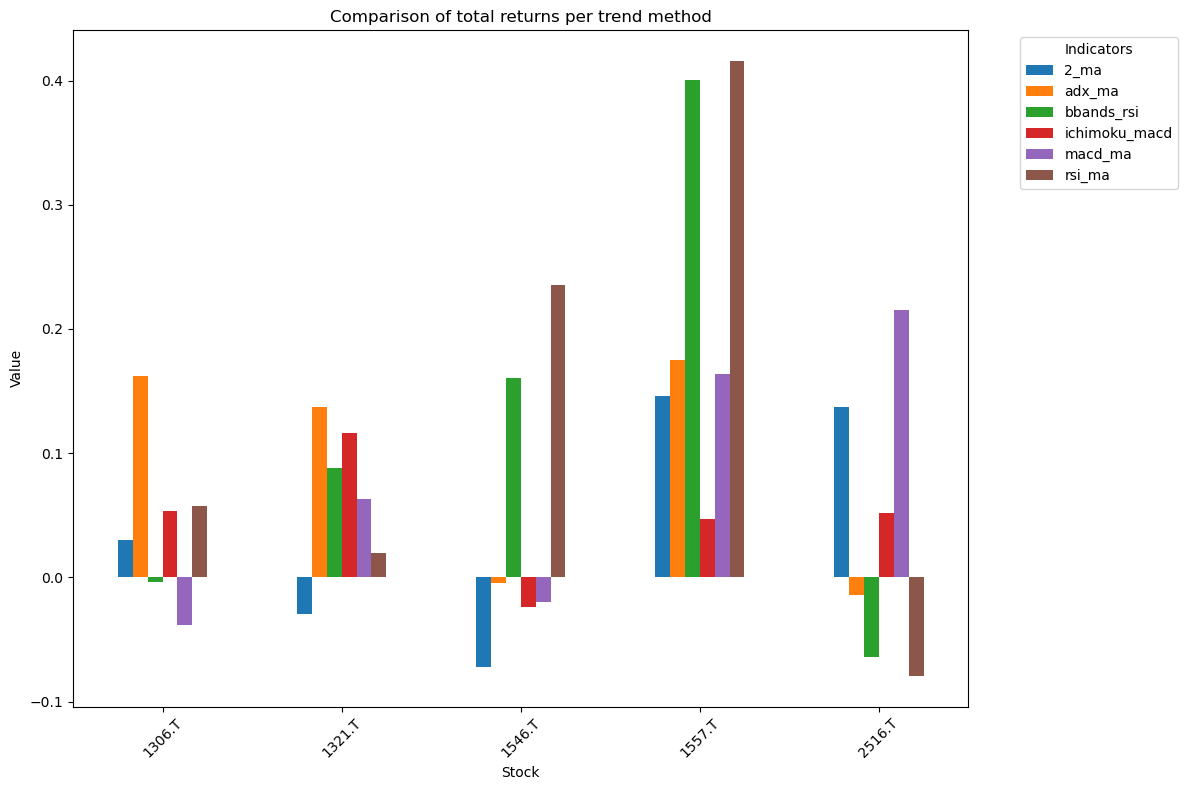

In [12]:
# 銘柄のリストについて、単一の評価指標による評価結果のグラフ化
# 銘柄リストの指定(ETF) 1306:TOPIX連動, 1321:日経平均連動, 1546:ダウ工業株30種連動, 1557:SP500連動, 2516:東証グロース250連動
tickers = ['1306.T', '1321.T', '1546.T', '1557.T', '2516.T']
results = []

for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    trend_identification_methods = ['2_ma', 'macd_ma', 'rsi_ma', 'bbands_rsi', 'adx_ma',  'ichimoku_macd']
    trend_identification_results = []

    def calculate_trend(df, method):
        if method == '2_ma':
            return calculate_trend_2_ma(df, period_slow=21, period_fast=9)
        elif method == 'macd_ma':
            return calculate_trend_macd_ma(df, ma_period=50, macd_fast=12, macd_slow=26, macd_signal=9)
        elif method == 'rsi_ma':
            return calculate_trend_rsi_ma(df, rsi_period=14, ma_fast=9, ma_slow=21)
        elif method == 'bbands_rsi':
            return calculate_trend_bbands_rsi(df, bbands_period=5, bbands_std=2, rsi_period=14)
        elif method == 'adx_ma':
            return calculate_trend_adx_ma(df, adx_period=14, fast_ma_period=14, slow_ma_period=50)
        elif method == 'ichimoku_macd':
            return calculate_trend_ichimoku_macd(df, macd_fast=12, macd_slow=26, macd_signal=9, tenkan=9, kijun=26, senkou=52)


    for method in trend_identification_methods:

        # Calculate results of returns for each method and append to the list
        df_copy = df.copy()
        d = {}
        d['Method'] = method
        df_copy['Trend'] = calculate_trend(df_copy, method)
        df_copy['Equity Curve'], stats = calculate_returns(df_copy, col_for_returns = 'Close', col_for_signal = 'Trend')
        results.append({'ticker':ticker, 'method':method, 'total_return':stats['total_return']})

test_df = pd.DataFrame(results)

# Pivot the DataFrame to prepare for plotting
pivot_df = test_df.pivot(index='ticker', columns='method', values='total_return')

# Plotting
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Comparison of total returns per trend method')
plt.ylabel('Value')
plt.xlabel('Stock')
plt.legend(title='Indicators', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()